In [1]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

/home/jo/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
y.head()

1    True
2    True
3    True
4    True
5    True
dtype: bool

In [3]:
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [ ]:
from tsfresh import extract_features

extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

Feature Extraction:  40%|████      | 4/10 [00:36<00:55,  9.24s/it]

In [ ]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y)

In [109]:
# data
import numpy as np
import pandas as pd
import vertica_python
import sqlalchemy as sa
import configparser

# visualization
import matplotlib.pyplot as plt 
plt.style.use(u'ggplot')
%matplotlib inline

In [110]:
config = configparser.ConfigParser()
config.read("config.txt")

conn_info = {'host': config.get("databases","vertica.host"),
             'port': config.getint("databases","vertica.port"),
             'user': config.get("databases","vertica.username"),
             'password': config.get("databases","vertica.password"),
             'database': config.get("databases","vertica.database"),
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}
conn = vertica_python.connect(**conn_info)

In [111]:
def sql_query(query_string): # columns):
    cur.execute(query_string)
    df = pd.DataFrame(cur.fetchall())
    # df.columns = columns
    return df

# Queries

## MAIN

### Cohort entity

#### WoW cohort values

In [114]:
#  , COUNT(DISTINCT a.user_id) as num_users

query_cohort_wow_value = """

    SELECT
    date_trunc('week', c.bux_account_created_dts)::date as report_week
    , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(exchange_rate, 1),0))::numeric(20,2) + SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(exchange_rate, 1),0))::numeric(20,2) as cohort_value
    FROM reporting.transactions a
    LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
    LEFT JOIN reporting.user_details c USING (user_id)
    WHERE c.bux_account_created_dts::date BETWEEN '2016-10-01' AND '2017-09-30'
    AND a.created_dts < c.bux_account_created_dts + interval '6 months'
    GROUP BY 1
    ORDER BY 1


"""

cohort_wow_values = sql_query(query_cohort_wow_value)
cohort_wow_values['cohort_value'] = cohort_wow_values['cohort_value'].astype(float)
cohort_wow_values.to_csv('data/cohort_wow_values.csv',index=False)
len(cohort_wow_values)

53

In [115]:
# cohort_wow_values['ARPU'] = (cohort_wow_values['cohort_value'] / cohort_wow_values['num_users']).astype(int)
cohort_wow_values.head()

,report_week,cohort_value
0,2016-09-26,7910.58
1,2016-10-03,26015.06
2,2016-10-10,78783.53
3,2016-10-17,20273.10
4,2016-10-24,32364.92


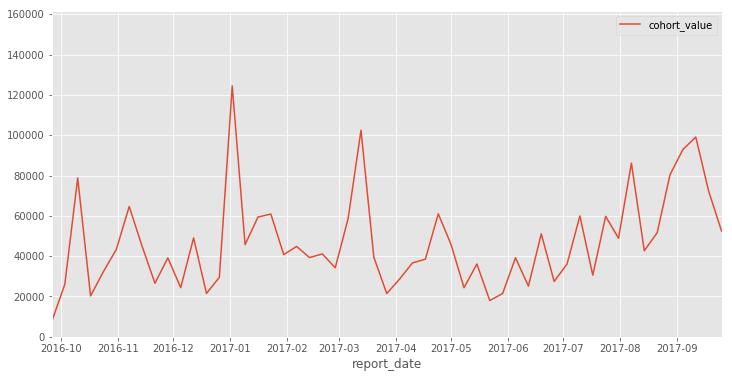

In [68]:
cohort_wow_values.set_index('report_date').plot(kind='line', ylim=(0,cohort_wow_values['cohort_value'].max()*1.3), figsize=(12,6));

#### Time series (price movement for each of the asset classes)

In [87]:
cohort_query_ts = """ 
    
            SELECT date_trunc('week', report_dts)::date as report_week, report_dts as date, product_type, AVG(close_price)::FLOAT as price
            FROM reporting.trading_quotes_candlestick 
            LEFT JOIN reporting.products b USING(product_id)
            WHERE duration = 'ONE_HOUR'
            AND report_dts BETWEEN '2016-10-01' AND '2017-09-30'
            GROUP BY 1,2,3
            ORDER BY 2,3
            
        """
cohort_ts = sql_query(cohort_query_ts)
cohort_ts['price'] = cohort_ts['price'].astype(float)
# cohort_ts.set_index('date', inplace=True)
cohort_ts.head()

,report_week,date,product_type,price
0,2016-09-26,2016-10-01 00:00:00,Stock,0.015
1,2016-09-26,2016-10-01 01:00:00,Stock,0.015
2,2016-09-26,2016-10-01 02:00:00,Stock,0.015
3,2016-09-26,2016-10-01 03:00:00,Stock,0.015
4,2016-09-26,2016-10-01 04:00:00,Stock,0.015


In [88]:
cohort_ts.to_csv('data/cohort_ts.csv', index=False)

In [89]:
len(cohort_ts)

34435

In [90]:
def plot_asset_class(product_type):
    cohort_ts[cohort_ts['product_type'] == product_type].set_index('date')[['price']].plot(kind='line', figsize=(10,6), title=product_type);

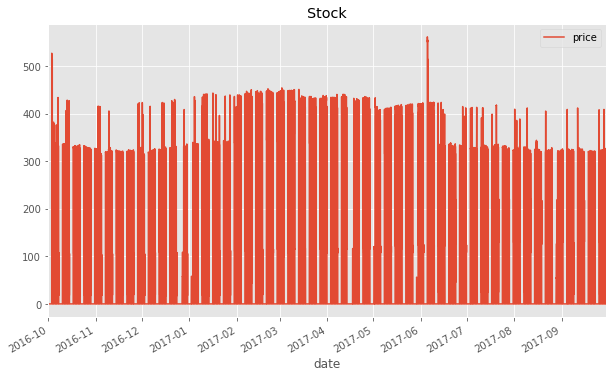

In [95]:
for product_type in list(cohort_ts['product_type'][2:4].unique()):
    plot_asset_class(product_type)

In [48]:
cohort_ts.head()

,year_week,date,product_type,price
0,2016-12-26,2017-01-01 00:00:00,Stock,0.015
1,2016-12-26,2017-01-01 01:00:00,Stock,0.015
2,2016-12-26,2017-01-01 02:00:00,Stock,0.015
3,2016-12-26,2017-01-01 03:00:00,Stock,0.015
4,2016-12-26,2017-01-01 04:00:00,Stock,0.015


In [50]:
# extracted_features = extract_features(cohort_ts[['year_week', 'product_type', 'price']], column_id="product_type", column_sort="year_week")
cohort_feature_matrix= extract_features(cohort_ts[['year_week', 'product_type', 'price']], column_id="year_week", column_sort="product_type")
cohort_feature_matrix






Feature Extraction:   0%|          | 0/6 [00:00<?, ?it/s]




Feature Extraction:  17%|█▋        | 1/6 [00:00<00:02,  1.93it/s]




Feature Extraction:  33%|███▎      | 2/6 [00:06<00:12,  3.20s/it]




Feature Extraction:  50%|█████     | 3/6 [00:08<00:08,  2.73s/it]




Feature Extraction:  67%|██████▋   | 4/6 [00:12<00:06,  3.23s/it]




Feature Extraction:  83%|████████▎ | 5/6 [00:13<00:02,  2.76s/it]




Feature Extraction: 100%|██████████| 6/6 [00:14<00:00,  2.47s/it]






variable,price__abs_energy,price__absolute_sum_of_changes,"price__agg_autocorrelation__f_agg_""mean""","price__agg_autocorrelation__f_agg_""median""","price__agg_autocorrelation__f_agg_""var""","price__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","price__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","price__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","price__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","price__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,price__time_reversal_asymmetry_statistic__lag_1,price__time_reversal_asymmetry_statistic__lag_2,price__time_reversal_asymmetry_statistic__lag_3,price__value_count__value_-inf,price__value_count__value_0,price__value_count__value_1,price__value_count__value_inf,price__value_count__value_nan,price__variance,price__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2016-12-26,3.796514e+02,19.432999,-0.128531,-0.045046,0.051808,16.209166,-0.866025,-9.716500,5.609824,NaN,...,-1.878919e+01,-2.588492e-01,-2.847342e-01,0.0,0.0,0.0,0.0,0.0,1.394960e+01,1.0
2017-01-02,6.451342e+09,70074.260578,0.754803,0.755340,0.018501,1105.928985,0.133227,24.368695,23.600635,1408.163130,...,1.167236e+07,1.130563e+08,1.026185e+08,0.0,0.0,0.0,0.0,0.0,8.337388e+06,1.0
2017-01-09,7.310726e+09,81021.141355,0.792450,0.792564,0.012910,900.350922,0.159042,26.008833,20.025757,1138.239654,...,2.208720e+07,-7.722608e+07,-6.756252e+07,0.0,0.0,0.0,0.0,0.0,8.591484e+06,1.0
2017-01-16,7.152673e+09,81351.853538,0.783193,0.785682,0.014667,993.909564,0.140901,23.553118,20.686572,1911.050408,...,8.993031e+07,2.164593e+07,-6.774005e+07,0.0,0.0,0.0,0.0,0.0,8.588847e+06,1.0
2017-01-23,7.362137e+09,85015.193021,0.790892,0.795817,0.013749,880.098971,0.165633,26.884172,19.854221,1151.737956,...,-1.112875e+08,-1.870320e+08,-2.793407e+08,0.0,0.0,0.0,0.0,0.0,8.650938e+06,1.0
2017-01-30,1.544913e+09,25929.722373,0.042727,-0.124444,0.220481,749.576812,0.264702,245.383392,269.536672,3386.861681,...,-1.769893e+08,-7.759842e+08,-7.772546e+08,0.0,0.0,0.0,0.0,0.0,9.196702e+06,1.0


### Vix

In [44]:
cohort_query_vix_normalized = """ 
    
            SELECT product_type, AVG(vix) as average_vix_norm
            FROM reporting.product_volatility
            WHERE report_date BETWEEN '2016-01-01' AND '2017-12-31'
            GROUP BY 1
            ORDER BY 1
        """
cohort_vix_normalized = sql_query(cohort_query_vix_normalized)
cohort_vix_normalized.head()

,product_type,average_vix_norm
0,Commodity,90.671756
1,Currency,94.802788
2,Future,84.693795
3,Index,85.868841
4,Stock,92.892268


In [45]:
# DROP TABLE IF EXISTS temp_users;
#             EXTRACT(year FROM report_date) as year, EXTRACT(week FROM report_date) as week

cohort_query_vix = """ 
    
            SELECT date_trunc('week', report_date)::date as report_week, product_type, AVG(vix) as average_vix
            FROM reporting.product_volatility
            WHERE report_date BETWEEN '2016-10-01' AND '2017-09-30'
            GROUP BY 1,2
            ORDER BY 1
        """
cohort_data = sql_query(cohort_query_vix)
cohort_data.head()

,report_week,product_type,average_vix
0,2016-10-03,Commodity,121.670178
1,2016-10-03,Currency,105.126720
2,2016-10-03,Future,55.977572
3,2016-10-03,Index,71.856906
4,2016-10-03,Stock,81.741464


In [46]:
# pivot table on the cohort data
cohort_data = cohort_data.pivot(index='report_week', columns='product_type', values='average_vix').reset_index()

# normalize by the average value in 2 years
def normalize_vix(column_name):
    return cohort_data[column_name] / int(cohort_vix_normalized[cohort_vix_normalized['product_type'] == column_name]['average_vix_norm'])

# apply to each of the columns
for column in cohort_data.columns[2:]:
    cohort_data[column + "_norm"] = normalize_vix(column)

# cohort_data.columns = [cohort_data.columns[0]] + [value + "_vix" for value in list(cohort_data.columns[1:])]
cohort_data.head()

product_type,report_week,Commodity,Currency,Future,Index,Stock,Currency_norm,Future_norm,Index_norm,Stock_norm
0,2016-10-03,121.670178,105.126720,55.977572,71.856906,81.741464,1.118369,0.666400,0.845375,0.888494
1,2016-10-10,76.958261,97.906805,64.388402,76.701221,81.688184,1.041562,0.766529,0.902367,0.887915
2,2016-10-17,60.807821,82.015868,51.020668,58.416466,75.005426,0.872509,0.607389,0.687253,0.815276
3,2016-10-24,74.638628,79.819829,61.388038,66.075777,84.903987,0.849147,0.730810,0.777362,0.922869
4,2016-10-31,86.643977,85.911707,74.717124,77.367756,90.401676,0.913954,0.889490,0.910209,0.982627


In [47]:
cohort_data.to_csv("data/cohorts.csv", index=False)

### Users entity

In [9]:
# DROP TABLE IF EXISTS temp_users;

query_users = """ 
        
            CREATE LOCAL TEMPORARY TABLE temp_users ON COMMIT PRESERVE ROWS AS
            SELECT user_id, country_cd, gender, nationality, platform_type_name, trading_experience, title, network, bux_account_created_dts, ams_first_funded_dts, initial_deposit_amount
            FROM reporting.user_details
            WHERE bux_account_created_dts::date BETWEEN '2016-10-01' AND '2017-09-30'
            LIMIT 3000 OVER (PARTITION BY date_trunc('month', bux_account_created_dts) ORDER BY RANDOMINT(1000000000));
        """
sql_query(query_users)

""


In [10]:
query_get_users = """
        SELECT a.*, nvl(b.segment_value, 'No Trades') as trading_segment, date_trunc('week', bux_account_created_dts)::date as report_week
        FROM temp_users a
        LEFT JOIN reporting.user_segments b
        ON b.segment_type = 'Trading Segment'
        AND b.user_id = a.user_id
        AND a.bux_account_created_dts::date + interval '3 weeks' between b.valid_from_date and b.valid_to_date
        LIMIT 1 OVER (PARTITION BY a.user_id ORDER BY valid_to_date desc)
"""
user_details = sql_query(query_get_users)
user_details.to_csv("data/users_1y_6mCustomerValue_3000.csv")
user_details.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,ams_first_funded_dts,initial_deposit_amount,trading_segment,report_week
0,003bfd2c-8ae8-473c-93ec-1b5729f8609f,DE,None,None,iOS,SOME,Experienced Trader,Organic,2017-01-03 18:13:22.059,NaT,None,No Trades,2017-01-02
1,0047ed0a-79f7-466d-9018-6793c8400d3f,IT,None,None,Android,NONE,Rookie Trader,Facebook Installs,2017-07-26 11:54:20.204,NaT,None,Stocks Trader,2017-07-24
2,006e9491-ae2f-4dea-ab3e-4ac464fb4d84,NL,None,None,iOS,NONE,Rookie Trader,Organic,2016-12-24 01:41:21.599,NaT,None,No Trades,2016-12-19
3,008b8352-bc5f-4d62-9448-0af4df21ca30,NL,None,None,Android,NONE,Rookie Trader,Facebook Installs,2017-03-12 20:35:38.015,NaT,None,No Trades,2017-03-06
4,00eaa7a7-d4c5-4e2a-9276-f4efabf7ea56,AT,None,None,iOS,NONE,Rookie Trader,Facebook Installs,2016-12-19 09:46:58.085,NaT,None,Mix Trader,2016-12-19


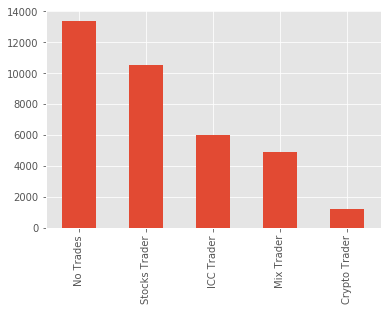

In [13]:
user_details['trading_segment'].value_counts().plot(kind='bar');

In [14]:
len(user_details)

36000

### Transactions entity

In [15]:
%%time

query_transactions= """

    SELECT a.user_id,
    a.date,
    trades_sb_invested_amount,
    financing_deposits_amount,
    trades_sb_short,
    trades_sb_long,
    view_position,
    trades_sb_open_positions,
    total_session_duration,
    education_topic_read,
    trades_fb_commission,
    trades_fb_forex_open,
    trades_sb_forex_open,
    conversion_to_sb,
    trades_fb_stocks_average_leverage,
    trades_sb_stocks_average_leverage,
    trades_sb_forex_average_leverage,
    trades_sb_forex_average_leverage
    
    FROM temp_users b
    JOIN calendar c ON c.date BETWEEN b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    LEFT JOIN reporting.cube_daily_user a ON a.user_id = b.user_id AND a.date = c.date
    

"""

cube_daily_user = sql_query(query_transactions)
cube_daily_user.to_csv('data/cube_1y_6mCustomerValue_3000.csv')

CPU times: user 3min 20s, sys: 16.3 s, total: 3min 36s
Wall time: 3min 38s


In [16]:
len(cube_daily_user), len(cube_daily_user['user_id'].unique())

(792000, 35192)

### Target values (6m current customer value)

In [17]:
%%time

query_curcv= """ 
        
        SELECT a.user_id
        , bux_account_created_dts
        , SUM(decode(b.transaction_type, 'COMMISSION',-amount * nvl(c.exchange_rate, 1),0))::numeric(20,2) as com
        , SUM(decode(b.transaction_type, 'DIVIDEND',-amount * nvl(c.exchange_rate, 1),0))::numeric(20,2) as div
        , SUM(decode(b.transaction_type, 'FINANCING_FEE',-amount * nvl(c.exchange_rate, 1),0))::numeric(20,2) as ff
        FROM temp_users a
        LEFT JOIN reporting.transactions b USING(user_id)
        LEFT JOIN reporting.exchange_rates_eur c on c.report_date = b.created_dts::date and c.currency = b.currency
        GROUP BY 1,2

"""

CurCV_whales = sql_query(query_curcv)
CurCV_whales.to_csv('data/curcv_1y_6mCustomerValue_3000.csv')
len(CurCV_whales)

CPU times: user 9.27 s, sys: 701 ms, total: 9.97 s
Wall time: 11 s


In [18]:
CurCV_whales.head()

,user_id,bux_account_created_dts,com,div,ff
0,6aa954b7-c6fa-470f-a75f-04623b9d9315,2017-08-31 13:43:23.679,0.00,0.00,0.00
1,0f48e10b-aa6a-459b-b0c1-bf93f44b9660,2016-12-17 23:17:00.697,0.00,0.00,0.00
2,6b4acc53-c1f6-4b4f-8f02-a43ce728483f,2017-09-16 09:50:41.177,0.00,0.00,0.00
3,9ff53541-5801-438b-bf56-7a2077b145a6,2017-02-01 20:06:19.634,0.00,0.00,0.00
4,afa1ab8f-3775-4d1f-899c-74d3f63def8d,2017-09-25 14:04:55.117,0.00,0.00,0.00


In [19]:
len(CurCV_whales)

36000

In [11]:
query= """ 
        
        SELECT * FROM temp_users

"""

temp_df = sql_query(query)
len(temp_df)

36000

In [13]:
%%time

query_curcv_large= """ 

        SELECT a.user_id, YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2016-10-01' AND '2017-09-30'
        GROUP BY 1,2) a
        
        LEFT JOIN (
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1,2,3
        ORDER BY 1,2

"""

CurCV_whales_large = sql_query(query_curcv_large)
CurCV_whales_large.to_csv('data/curcv_1y_6mCustomerValue.csv')
len(CurCV_whales_large)

CPU times: user 1min 2s, sys: 8.49 s, total: 1min 11s
Wall time: 1min 14s


In [14]:
len(CurCV_whales_large)

565983

## Current customer value (CurCV)

In [141]:
query_curcv_feb17 = """ 

        SELECT a.user_id, sum(b.commission) as com, sum(b.dividend) as div, sum(b.financing_fee) as ff
        FROM (
        
        SELECT user_id
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-02-01' AND '2017-03-01') a
        

        LEFT JOIN (
        
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , sum(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , sum(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , sum(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '12 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY a.user_id

"""

CurCV_feb17 = sql_query(query_curcv_feb17)
CurCV_feb17[0:5]

,user_id,com,div,ff
0,3e675443-9762-4137-b92e-3cbcea38e44a,None,None,None
1,0de77d85-f73d-4798-90e2-7bc4de4f74dd,None,None,None
2,6f40a1bf-1d49-4d6a-8c6f-683526189f9e,None,None,None
3,20544428-b6fa-46be-9b82-25d064e3650f,None,None,None
4,076e3239-a377-4cbb-81ed-8f16a3197a5d,None,None,None


### Query superbuxer

In [9]:
query_superbuxer = """

SELECT
     COUNT (DISTINCT a.user_id)
FROM
     reporting.user_details a
JOIN
     reporting.user_type b
USING
     (user_id)
WHERE
     year (bux_account_created_dts) = 2017
 AND b.date <= a.bux_account_created_dts + interval '1 year'
 AND b.user_type = 'SuperBUXer'
 
 
"""

super_buxer_unique_count_2016 = sql_query(query_superbuxer)
super_buxer_unique_count_2016[0:5]

,COUNT
0,219


### Distinct BUX classses

In [26]:
query_user_classes = """

SELECT
     DISTINCT b.user_type
FROM
     reporting.user_details a
JOIN
     reporting.user_type b
USING
     (user_id)
WHERE
     year (bux_account_created_dts) = 2017
 AND b.date <= a.bux_account_created_dts + interval '1 year'
 
 
"""

user_classes = sql_query(query_user_classes)
user_classes[0:5]

,user_type
0,SuperBUXer
1,Ex-SeriousBUXer
2,FunBUXer
3,Prospect On Risk
4,SeriousBUXer


### Value of chorts MoM (6 months)

In [6]:
# query_mom_curcv = """ 

#         SELECT YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), COUNT(DISTINCT a.user_id), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
#         FROM (
        
#         SELECT user_id, bux_account_created_dts
#         FROM reporting.user_details
#         WHERE bux_account_created_dts::date BETWEEN '2016-01-01' AND '2016-12-31'
#         GROUP BY 1,2) a
        

#         LEFT JOIN (
        
        
#         SELECT
#         a.user_id
#         , created_dts::date as report_date
#         , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
#         , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
#         , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
#         FROM reporting.transactions a
#         LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
#         LEFT JOIN reporting.user_details c USING(user_id)
#         WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
#         GROUP BY 1,2
#         ORDER BY 1 ) b
        
#         ON a.user_id = b.user_id
#         GROUP BY 1, 2
#         ORDER BY 1,2

# """

# CurCV_MoM = sql_query(query_mom_curcv)
# CurCV_MoM[0:5]

In [ ]:
CurCV_MoM["YEAR_MONTH"] = pd.Series([str(row["YEAR"]) + "-0" + str(row["MONTH"])  if row["MONTH"] <= 9 else str(row["YEAR"]) + "-" + str(row["MONTH"]) for index, row in CurCV_MoM.iterrows()])
CurCV_MoM["YEAR_MONTH"] = pd.to_datetime(CurCV_MoM["YEAR_MONTH"])
CurCV_MoM["CLV"] = CurCV_MoM["com"] + CurCV_MoM["ff"] # CurCV_MoM["div"]
CurCV_MoM[["CLV", "com", "div", "ff"]]=CurCV_MoM[["CLV", "com", "div", "ff"]].astype(float)
CurCV_MoM["CLV/user"] = CurCV_MoM["CLV"] / CurCV_MoM["COUNT"]
CurCV_MoM.head()

In [ ]:
CurCV_MoM.to_csv("users_1y_6mCustomerValue.csv")

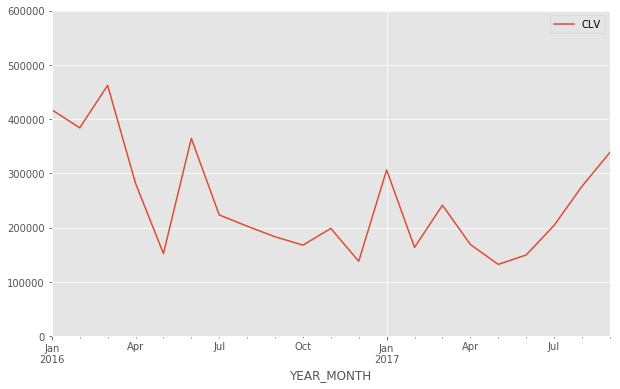

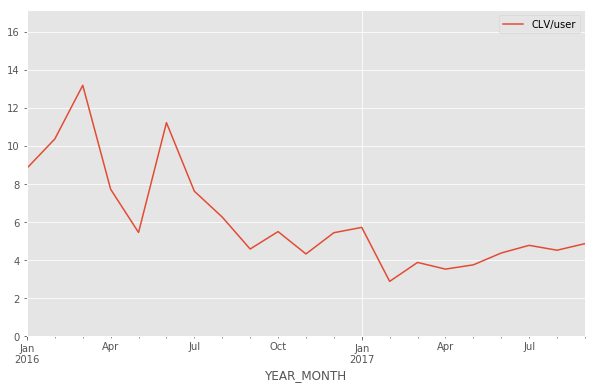

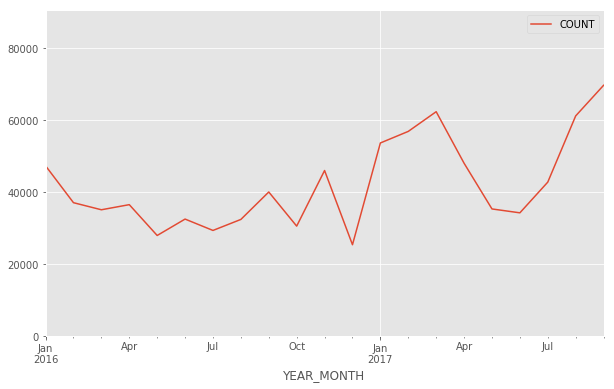

In [115]:
CurCV_MoM.plot(x='YEAR_MONTH', y='CLV', figsize=(10,6), ylim=(0,max(CurCV_MoM["CLV"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='CLV/user', figsize=(10,6), ylim=(0,max(CurCV_MoM["CLV/user"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='COUNT', figsize=(10,6), ylim=(0,max(CurCV_MoM["COUNT"])*1.3));

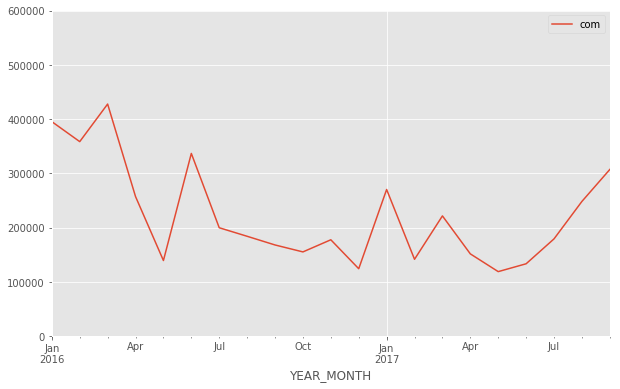

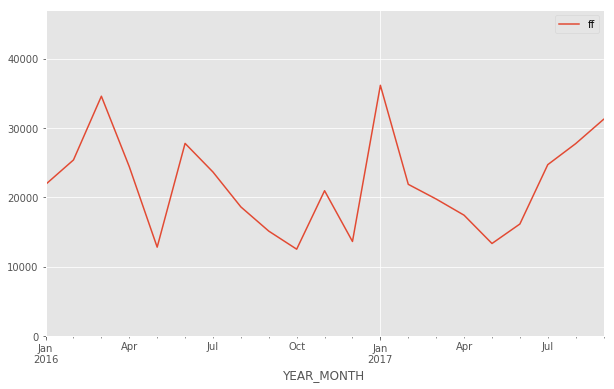

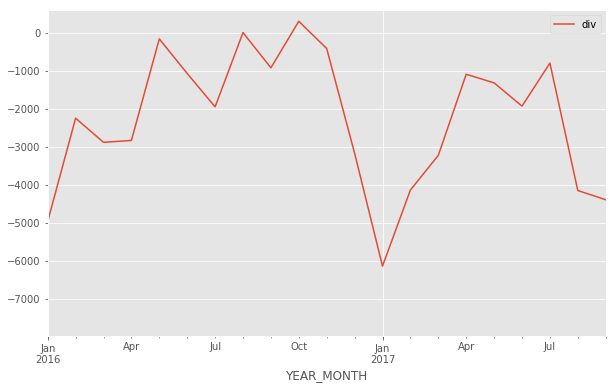

In [116]:
CurCV_MoM.plot(x='YEAR_MONTH', y='com', figsize=(10,6), ylim=(0,max(CurCV_MoM["CLV"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='ff', figsize=(10,6), ylim=(0,max(CurCV_MoM["ff"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='div', figsize=(10,6), ylim=(min(CurCV_MoM["div"])*1.3,max(CurCV_MoM["div"])*2));

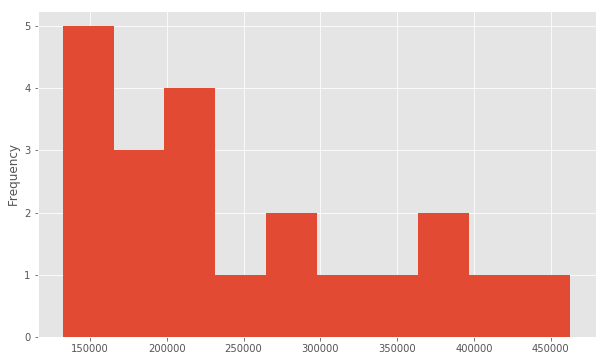

In [112]:
CurCV_MoM["CLV"].plot(kind='hist',bins=10,figsize=(10,6));

In [113]:
CurCV_MoM["CLV"].describe()

count        21.000000
mean     245726.117143
std       98897.728338
min      132421.660000
25%      167950.960000
50%      204179.810000
75%      306650.600000
max      462606.420000
Name: CLV, dtype: float64

#### 50% of 6 month value of monthly cohorts are fall between 170k and 300k

### Distribution of whales MoM

In [13]:
conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')

In [14]:
%%time

query_curcv_whales_1 = """ 

        SELECT a.user_id, YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2016-10-01' AND '2016-12-31'
        GROUP BY 1,2) a
        
        LEFT JOIN (
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1,2,3
        ORDER BY 1,2

"""

CurCV_whales_1 = sql_query(query_curcv_whales_1)
CurCV_whales_1.to_csv("data/partitioned_data/part_1/curcv.csv")
len(CurCV_whales_1)

CPU times: user 12.7 s, sys: 1.6 s, total: 14.3 s
Wall time: 18.2 s


In [16]:
%%time

query_curcv_whales_2 = """ 

        SELECT a.user_id, YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-01-01' AND '2017-03-31'
        GROUP BY 1,2) a
        
        LEFT JOIN (
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1,2,3
        ORDER BY 1,2

"""

CurCV_whales_2 = sql_query(query_curcv_whales_1)
CurCV_whales_2.to_csv("data/partitioned_data/part_2/curcv.csv")
len(CurCV_whales_2)

CPU times: user 24.3 s, sys: 2.81 s, total: 27.1 s
Wall time: 31.8 s


In [18]:
%%time

query_curcv_whales_3 = """ 

        SELECT a.user_id, YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-04-01' AND '2017-06-30'
        GROUP BY 1,2) a
        
        LEFT JOIN (
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1,2,3
        ORDER BY 1,2

"""

CurCV_whales_3 = sql_query(query_curcv_whales_1)
CurCV_whales_3.to_csv("data/partitioned_data/part_3/curcv.csv")
len(CurCV_whales_3)

CPU times: user 16 s, sys: 1.56 s, total: 17.6 s
Wall time: 21.3 s


In [7]:
%%time

query_curcv_whales_4 = """ 

        SELECT a.user_id, YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-07-01' AND '2017-09-30'
        GROUP BY 1,2) a
        
        LEFT JOIN (
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1,2,3
        ORDER BY 1,2

"""

CurCV_whales_4 = sql_query(query_curcv_whales_4)
CurCV_whales_4.to_csv("data/partitioned_data/part_4/curcv.csv")
len(CurCV_whales_4)

CPU times: user 20.8 s, sys: 2.44 s, total: 23.2 s
Wall time: 26.9 s


In [67]:
len(CurCV_whales_1) + len(CurCV_whales_2) + len(CurCV_whales_3) + len(CurCV_whales_4)

565983

In [68]:
CurCV_whales = CurCV_whales_1.append(CurCV_whales_2).append(CurCV_whales_3).append(CurCV_whales_4)

In [69]:
len(CurCV_whales)

565983

In [70]:
%%time

CurCV_whales["YEAR_MONTH"] = pd.Series([str(row["YEAR"]) + "-0" + str(row["MONTH"])  if row["MONTH"] <= 9 else str(row["YEAR"]) + "-" + str(row["MONTH"]) for index, row in CurCV_whales.iterrows()])

CPU times: user 2min 52s, sys: 279 ms, total: 2min 52s
Wall time: 2min 53s


In [71]:
CurCV_whales.to_csv('data/curcv_1y_6mCustomerValue.csv')

In [45]:
%%time

CurCV_whales["YEAR_MONTH"] = pd.to_datetime(CurCV_whales["YEAR_MONTH"])
CurCV_whales = CurCV_whales.fillna(0)
CurCV_whales["CLV"] = CurCV_whales["com"] + CurCV_whales["ff"] # + CurCV_whales["div"]
CurCV_whales[["CLV", "com", "div", "ff"]]=CurCV_whales[["CLV", "com", "div", "ff"]].astype(float)
CurCV_whales.head()

CPU times: user 433 ms, sys: 91 µs, total: 433 ms
Wall time: 459 ms


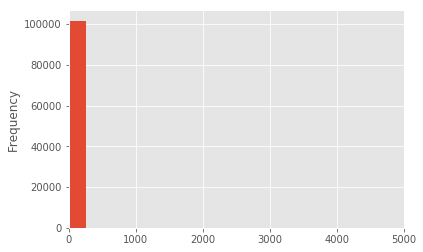

In [46]:
CurCV_whales["CLV"].plot(kind='hist',bins=100, xlim=(0,5000));

In [47]:
len(CurCV_whales[CurCV_whales["CLV"] == 0])

98708

In [48]:
CurCV_whales["CLV"].describe()

count    101955.000000
mean          4.950874
std         160.971694
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       25601.400000
Name: CLV, dtype: float64

In [49]:
whale_threshold = CurCV_whales['CLV'].quantile(0.99)
whale_threshold

38.57

In [50]:
CurCV_whales["YEAR_MONTH"].min(), CurCV_whales["YEAR_MONTH"].max()

(Timestamp('2016-10-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

### 6 month whale value threshold:

#### 2016-01 -> 2017-09 = 50 euros, mean = 6 euros, std = 184, 8800 whales
#### 2016-01 -> 2016-12 = 50 euros, mean = 5.8 euros, std = 184, 5000 whales)
#### 2017-01 -> 2017-09 = 

In [294]:
len(CurCV_whales[CurCV_whales["CLV"] > whale_threshold])

5059

In [ ]:
CurCV_whales[CurCV_whales["CLV"] > whale_threshold]["CLV"].plot(kind='bar')

In [ ]:
# pd.DataFrame(serious_buxers).reset_index().hist(cumulative=True, normed=1, bins=100);

In [223]:
conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')

# Downsampling (later in the pipeline, after splitting train/test)

In [37]:
len(CurCV_1yCohort_6mCurCV)

565983

In [40]:
CurCV_1yCohort_6mCurCV["CLV"] = CurCV_1yCohort_6mCurCV["CLV"].astype(float)
CurCV_1yCohort_6mCurCV = CurCV_1yCohort_6mCurCV.fillna(0)
CurCV_1yCohort_6mCurCV["whale"] = (CurCV_1yCohort_6mCurCV["CLV"] > 50).astype(int)
CurCV_1yCohort_6mCurCV["whale"].value_counts()

0    561372
1      4611
Name: whale, dtype: int64

In [64]:
num_of_whales = len(CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["whale"] == 1])
num_of_whales

4611

In [60]:
CurCV_1yCohort_6mCurCV.sort_values(by="CLV", ascending=False)[0:15]

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
381732,acb6d13f-27f3-420e-8cef-d80fb7813fc2,2017-08-07 19:13:11.542,28269.25,-1302.31,2163.13,29130.07,1,29130.07
492888,df02e3b2-f83f-428f-8bda-c0f5293e6ddb,2016-10-11 05:53:56.543,24997.81,-90.13,603.59,25511.27,1,25511.27
124094,3841e8eb-c047-47b9-b1bb-aa117ca8121d,2017-06-25 10:23:10.752,22839.71,-91.43,1548.12,24296.40,1,24296.40
363591,a48ddf05-9e18-4c05-9514-bbb2de8b304e,2017-09-15 12:02:13.293,22676.53,-25.20,319.18,22970.51,1,22970.51
466948,d363380d-1e19-4c0d-98f5-0c97d6a514b9,2017-03-14 18:38:21.261,20530.05,0.00,1157.35,21687.40,1,21687.40
66173,1dfd5300-f30c-4e99-86bc-b158559e4dfc,2016-12-15 15:34:56.919,20472.92,-1625.86,2207.44,21054.50,1,21054.50
369551,a73a431f-b8f8-4a9c-b839-0091be9e4433,2016-10-12 23:00:48.589,19447.61,11.26,184.08,19642.95,1,19642.95
83251,25cf9821-ddb1-4c66-861d-bcc30b6d49c0,2017-01-13 20:10:43.712,11878.21,1308.34,5065.89,18252.44,1,18252.44
323265,923492d8-d04e-49a1-9c60-8c95d4597d4c,2016-11-07 00:22:56.164,14303.56,8.57,860.87,15173.00,1,15173.00
201655,5b484d6e-9003-4878-95b3-bd20e4bbdbab,2017-09-09 14:35:04.904,14076.76,-795.11,1616.62,14898.27,1,14898.27


In [96]:
CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["CLV"] < -100]

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
277645,7d903ec2-62fb-4461-860a-6b61fa94c0dc,2017-05-09 20:25:26.566,35.30,-402.13,74.90,-291.93,0,-291.93
418226,bd50b13a-3890-4b15-b7c5-7fe3c534e4ba,2017-01-25 13:36:23.838,1996.15,-5652.77,792.31,-2864.31,0,-2864.31


In [44]:
CurCV_1yCohort_6mCurCV["CLV"].describe()

count    565983.000000
mean          4.340459
std         137.687575
min       -2864.310000
25%           0.000000
50%           0.000000
75%           0.000000
max       29130.070000
Name: CLV, dtype: float64

In [42]:
CurCV_1yCohort_6mCurCV.head()

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
0,00001025-a69f-498c-be1e-6fc4ec96453b,2016-10-01 07:48:23.647,0,0,0,0,0,0.0
1,00001e00-0bc0-4de5-a212-c19a9afe0dc0,2017-08-21 07:05:33.269,0,0,0,0,0,0.0
2,00003ad5-d62d-4a88-ae32-558b9ac70915,2017-01-22 18:43:34.760,0,0,0,0,0,0.0
3,0000656b-8703-4505-917d-652b80545a1f,2017-09-28 11:04:33.659,0,0,0,0,0,0.0
4,00008058-2e3f-42dd-a9d7-8ee371d876ab,2017-05-10 13:26:35.931,0,0,0,0,0,0.0


In [69]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["whale"] == 0]
df_minority = CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["whale"] == 1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_of_whales*10,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled["whale"].value_counts()

0    46110
1     4611
Name: whale, dtype: int64

In [70]:
df_downsampled

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
305729,8a35d43b-b4be-4c0c-82c1-bee7b760bd87,2016-12-26 13:20:05.768,0,0,0,0,0,0.00
262165,76a63b6c-b839-4940-a09d-f3c7d312eaaa,2017-09-15 17:23:47.783,0,0,0,0,0,0.00
379319,aba37f50-7dd7-43e4-8110-557c892b90b1,2016-11-01 14:51:27.960,0,0,0,0,0,0.00
220680,64095894-06e8-49bf-a265-a9ac02bb8d29,2017-05-15 17:34:36.036,0,0,0,0,0,0.00
147611,42e702f2-a492-43fd-8e45-13fa53f4a351,2017-07-24 18:36:57.613,0,0,0,0,0,0.00
316664,8f3c08f8-d9b8-469a-a43f-af4947c7c325,2016-10-19 19:54:50.773,0,0,0,0,0,0.00
137602,3e549c63-b57d-4a8e-8db7-b5440dd4b25d,2017-04-17 17:17:26.015,0,0,0,0,0,0.00
324149,9297cc15-ed40-464a-850b-447ea5405f60,2016-12-27 23:55:21.909,0,0,0,0,0,0.00
348172,9d8548ae-d4da-4e4c-8398-499ebd5e892b,2017-01-02 12:03:34.071,0,0,0,0,0,0.00
254209,730c54b2-8b55-4a4f-b696-fb5f81226a1c,2017-02-14 20:02:47.074,0,0,0,0,0,0.00


In [ ]:
# # test


# df_installs_no_signups = sql_query(""" select lower (trim (coalesce (a.idfa, a.android_id, a.gps_adid))) as device_id, a.country_cd, a.report_dts
#     from
#          reporting.adjust_installs a
#     left join
#          reporting.user_view b
#       on
#          lower (trim (b.device_id)) = lower (trim (coalesce (a.idfa, a.android_id, a.gps_adid)))
#     where
#          a.user_id is null
#      and b.user_id is null
#      and a.report_dts::date = current_date - 6 """)